# Data assimilation for FEM solutions on the dyadic-subdivided unit square

In [55]:
import numpy as np
import importlib
import dyadic_fem as df
import matplotlib.pyplot as plt
importlib.reload(df)
%matplotlib inline

### First we make our solution $u_h(x,y)$ for $h=2^{-\mathtt{fem-div}}$, and field $a(x,y)$
Again we solve the problem $-\nabla \cdot (a(x,y) \nabla u(x,y)) = f(x,y)$ using FEM. We then construct a basis of hat functions and sin functions on the grid of dyadic level $\mathtt{coarse\_div}$, both of which we also orthonormalise. Approximation in both the sin and hat functions should be the same as the bases span the same subspace of dyadic piece-wise linear functions

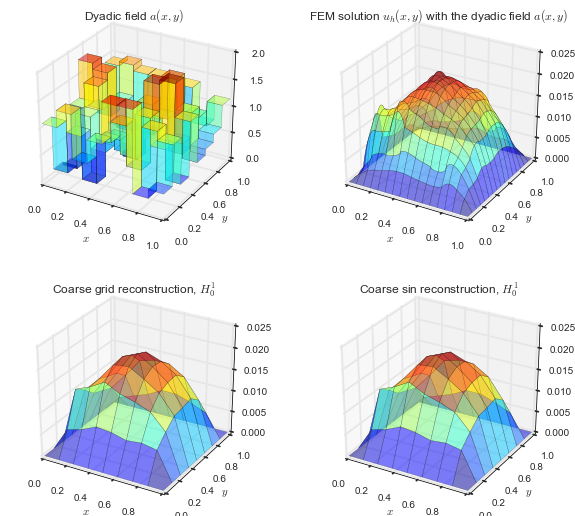

In [56]:
importlib.reload(df)

field_div = 3
fem_div = 8
coarse_div = 3

# First we generate our solution
a = df.DyadicRandomField(div=field_div, a_bar=1.0, c=0.99, seed=3)
fem = df.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

coarse_grid = 2**coarse_div - 1
# Now make our bases
hat_b = df.make_hat_basis(coarse_div, space='H1')
sin_b = df.make_sine_basis(coarse_div, N=coarse_grid, M=coarse_grid, space='H1')

hat_b_ortho = hat_b.orthonormalise()
sin_b_ortho = sin_b.orthonormalise()

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a.field.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
hat_b.project(fem.u).plot(ax, title='Coarse grid reconstruction, $H^1_0$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
sin_b.project(fem.u).plot(ax, title='Coarse sin reconstruction, $H^1_0$')

### We take average value around a point as our measurement, which has a representer of a simple indicator function around that point

n=49, m=225. Remember we require n <= m!


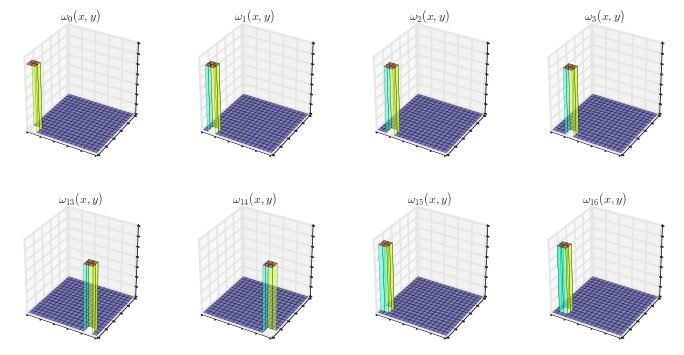

In [57]:
# And now make our measurements
meas_div = 4
M_m = []
for i in range(2**meas_div-1):
    for j in range(2**meas_div-1):
        h = 2**(-meas_div)
        meas = df.DyadicPWConstant(div=meas_div)
        meas.values[i:i+2,j:j+2] = 1.0 / (4*h*h)
        
        M_m.append(meas)
measurement_b = df.Basis(M_m, 'H1')

# Remember we need n = len(basis) to be less than m = len(measurements)
print("n={0}, m={1}. Remember we require n <= m!".format(len(sin_b.vecs), len(M_m)))

c = np.zeros(len(M_m))
for meas in M_m:
    fem.u.dot(meas, 'H1')
    
show_n = 4
fig = plt.figure(figsize=(12, 6))
for i in range(show_n):
    ax = fig.add_subplot(2, show_n, i+1, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    measurement_b.vecs[i].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i), show_axes_labels=False)

    ax = fig.add_subplot(2, show_n, i+1+show_n, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    measurement_b.vecs[i+13].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i+13), show_axes_labels=False)
    

In [67]:
G_hat = hat_b.cross_grammian(measurement_b)
G_sin = sin_b.cross_grammian(measurement_b)
G_hat_ortho = hat_b_ortho.cross_grammian(measurement_b)
G_sin_ortho = sin_b_ortho.cross_grammian(measurement_b)

hat_cond = np.linalg.cond(G_hat.T @ G_hat)
sin_cond = np.linalg.cond(G_sin.T @ G_sin)
hat_ortho_cond = np.linalg.cond(G_hat_ortho.T @ G_hat_ortho)
sin_ortho_cond = np.linalg.cond(G_sin_ortho.T @ G_sin_ortho)

# Now the magic: the system we want to solve. 
print('Condition number, hat basis:\t {0}'.format(hat_cond))
print('Condition number, sin basis:\t {0}'.format(sin_cond))
print('Condition number, orthonormal hat basis:\t {0}'.format(hat_ortho_cond))
print('Condition number, orthonormal sin basis:\t {0}'.format(sin_ortho_cond))

np.set_printoptions(precision=4)
print(G_hat[:9,:9])
print((G_hat.T @ G_hat)[:9,:9])

Condition number, hat basis:	 6.8706427720563474e+19
Condition number, sin basis:	 2.3490639426973056e+18
Condition number, orthonormal hat basis:	 1.4775367675004514e+19
Condition number, orthonormal sin basis:	 1.066789345446023e+19
[[ 0.2292  0.375   0.2708  0.0729  0.      0.      0.      0.      0.    ]
 [ 0.      0.0521  0.2292  0.375   0.2708  0.0729  0.      0.      0.    ]
 [ 0.      0.      0.      0.0521  0.2292  0.375   0.2708  0.0729  0.    ]
 [ 0.      0.      0.      0.      0.      0.0521  0.2292  0.375   0.2708]
 [ 0.      0.      0.      0.      0.      0.      0.      0.0521  0.2292]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]]
[[ 0.0525  0.0859  0.0621  0.0167  0.      0.      0.      0.      0.    ]
 [ 0.0859  0.1

Wow. Those are some big condition numbers... so how do we reduce this? Ah of course we were meant to orthonormalise the measurements too....

In [59]:
measurement_b_ortho = measurement_b.orthonormalise()

G_hat = hat_b.cross_grammian(measurement_b_ortho)
G_sin = sin_b.cross_grammian(measurement_b_ortho)
G_hat_ortho = hat_b_ortho.cross_grammian(measurement_b_ortho)
G_sin_ortho = sin_b_ortho.cross_grammian(measurement_b_ortho)

hat_cond = np.linalg.cond(G_hat.T @ G_hat)
sin_cond = np.linalg.cond(G_sin.T @ G_sin)
hat_ortho_cond = np.linalg.cond(G_hat_ortho.T @ G_hat_ortho)
sin_ortho_cond = np.linalg.cond(G_sin_ortho.T @ G_sin_ortho)

# Now the magic: the system we want to solve. 
print('Condition number, hat basis:\t {0}'.format(hat_cond))
print('Condition number, sin basis:\t {0}'.format(sin_cond))
print('Condition number, orthonormal hat basis:\t {0}'.format(hat_ortho_cond))
print('Condition number, orthonormal sin basis:\t {0}'.format(sin_ortho_cond))

print(G_hat[:4,:4])

Condition number, hat basis:	 6.539109468282162e+19
Condition number, sin basis:	 5.022271313011167e+18
Condition number, orthonormal hat basis:	 9.197332927845094e+19
Condition number, orthonormal sin basis:	 7.220178840936322e+19
[[  2.86458333e-02   3.75879082e-02   1.48840523e-02   5.78241159e-18]
 [  0.00000000e+00   7.51758163e-03   2.97681045e-02   3.62344315e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.23509807e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]
